# Apr 24th, 2022 (findk both 128 and 512)

**Motivation**: 
<br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import fnmatch

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6), 'bold': 'dimgrey'}

percentiles = np.linspace(35, 5, 7).astype(int)

## 128 * 3

In [3]:
mice = Mice(Config(128, 3))
mice.setup_func_data('rest', runs_only=True)

In [4]:
pat = f"n-{mice.cfg.nn}[*]{mice.cfg.ll}_*_run-[1-7]"
dirs = fnmatch.filter(os.listdir(mice.cfg.svinet_dir), pat)
df = collections.defaultdict(list)
for item in sorted(dirs):
    mode = item.split('_')[1]
    key = '_'.join(item.split('_')[-3:])
    for p in percentiles:
        for cond in ['sample', 'binary']:
            perc = f"p{p}-{cond}"
            path = pjoin(mice.cfg.svinet_dir, item, 'real', perc)
            findk = fnmatch.filter(os.listdir(path), '*-mmsb-findk')
            if not len(findk):
                continue
            path = pjoin(path, findk.pop())
            
            with open(pjoin(path, 'communities.txt')) as f:
                lines = f.readlines()
            
            df['mode'].append(mode)
            df['key'].append(key)
            df['p'].append(p)
            df['cond'].append(cond)
            df['k'].append(len(lines))
df = pd.DataFrame(df)

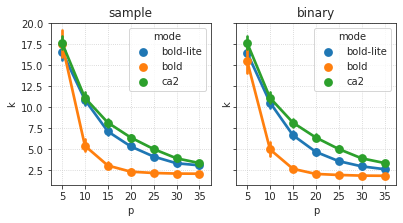

In [5]:
fig, axes = create_figure(1, 2, (5.7, 3.2), 'all', 'all')
for ax, cond in zip(axes.flat, df['cond'].unique()):
    sns.pointplot(
        data=df.loc[df['cond'] == cond],
        x='p',
        y='k',
        hue='mode',
        ax=ax,
    )
    ax.set_title(cond)
    ax.grid()
plt.show()

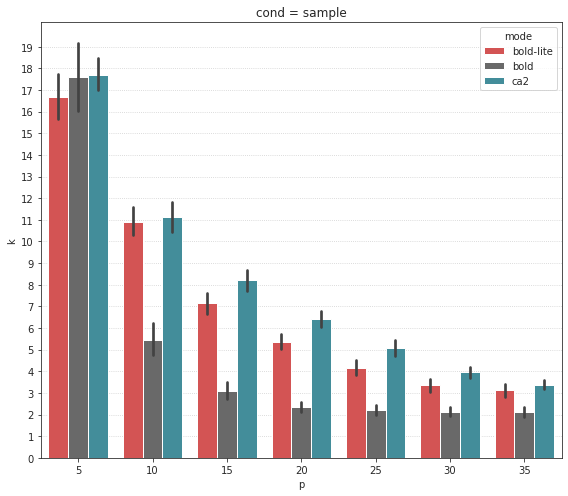

In [6]:
fig, ax = create_figure(figsize=(8, 7))

sns.barplot(
    data=df.loc[df['cond'] == 'sample'],
    x='p',
    y='k',
    hue='mode',
    palette=pal,
    ax=ax,
)
ax.set_yticks(range(20))
ax.grid(axis='y')
ax.set_title('cond = sample')
plt.show()

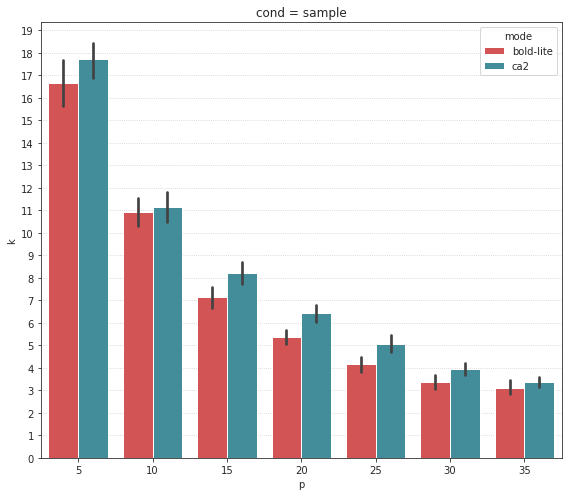

In [12]:
fig, ax = create_figure(figsize=(8, 7))
_df = df.loc[
    (df['mode'] != 'bold') &
    (df['cond'] == 'sample')
]
sns.barplot(
    data=_df,
    x='p',
    y='k',
    hue='mode',
    palette=pal,
    ax=ax,
)
ax.set_yticks(range(20))
ax.grid(axis='y')
ax.set_title('cond = sample')
plt.show()

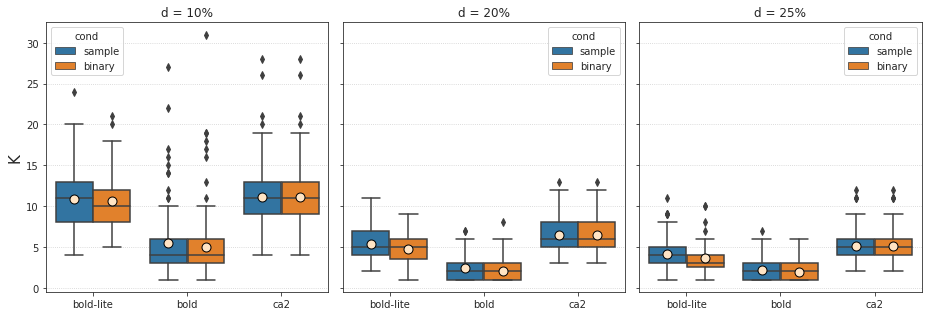

In [13]:
meanprops = {
    'markerfacecolor': 'bisque',
    'marker': 'o',
    'markersize': 9,
    "markeredgecolor":"k",
}

fig, axes = create_figure(1, 3, (13, 4.5), 'all', 'all')
for ax, p in zip(axes.flat, [10, 20, 25]):
    sns.boxplot(
        data=df.loc[df['p'] == p],
        y='k',
        hue='cond',
        x='mode',
        showmeans=True,
        meanprops=meanprops,
        ax=ax,
    )
    ax.grid(axis='y')
    ax.set_xlabel('')
    ax.set_title(f"d = {p}%")
    ax.set_ylabel('K' if p == 10 else '', fontsize=15)
plt.show()

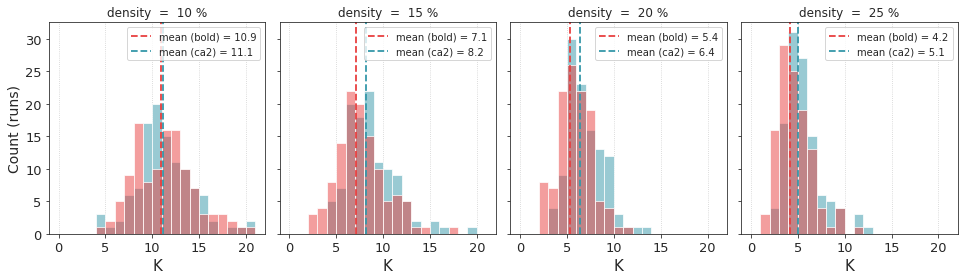

In [59]:
fig, axes = create_figure(1, 4, (13.5, 4), 'all', 'all')
for ax, p in zip(axes.flat, [10, 15, 20, 25]):
    _df = df.loc[
        (df['p'] == p) &
        (df['mode'] != 'bold') &
        (df['cond'] == 'sample')
    ]
    sns.histplot(
        data=_df,
        x='k',
        hue='mode',
        palette=pal,
        stat='count',
        bins=np.linspace(0, 21, 22),
        ax=ax,
    )
    _df = _df.groupby(['mode']).mean().reset_index().drop(columns='p')
    for mode, x in dict(zip(_df['mode'], _df['k'])).items():
        ax.axvline(x, ls='--', lw='1.8', color=pal[mode], label=f"mean ({mode.split('-')[0]}) = {x:0.1f}")
    ax.legend()
    ax.set_title(f'density  =  {p} %')
    ax.set_xlabel('K', fontsize=15)
    ax.set_ylabel('Count (runs)', fontsize=14)
    ax.tick_params(labelsize=13)
    ax.grid(axis='x', ls=':')
plt.show()

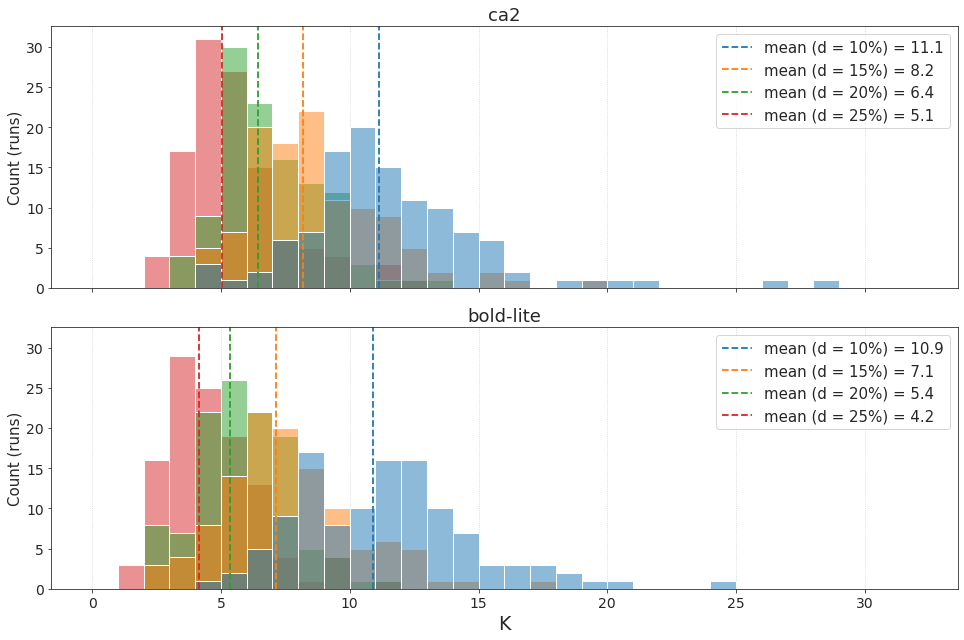

In [88]:
palette = sns.color_palette('tab10', n_colors=4)
fig, axes = create_figure(2, 1, (13.5, 9), 'all', 'all')
for ax, mode in zip(axes.flat, ['ca2', 'bold-lite']):
    _df = df.loc[
        (df['mode'] == mode) &
        (df['p'].isin([10, 15, 20, 25])) &
        (df['cond'] == 'sample')
    ]
    sns.histplot(
        data=_df,
        x='k',
        hue='p',
        palette=palette,
        stat='count',
        bins=np.linspace(0, 32, 33),
        ax=ax,
    )
    _df = _df.groupby(['p']).mean().reset_index()#.drop(columns='mode')
    for i, (p, x) in enumerate(dict(zip(_df['p'], _df['k'])).items()):
        ax.axvline(x, ls='--', lw='1.8', color=palette[i], label=f"mean (d = {p}%) = {x:0.1f}")
    ax.legend(fontsize=15)
    ax.set_title(mode, fontsize=18)
    ax.set_xlabel('K', fontsize=19)
    ax.set_ylabel('Count (runs)', fontsize=15)
    ax.tick_params(labelsize=14)
    ax.grid(axis='x', ls=':')
plt.show()

## 512 * 3

In [17]:
mice = Mice(Config(512, 3))
mice.setup_func_data('rest', runs_only=True)

In [18]:
pat = f"n-{mice.cfg.nn}[*]{mice.cfg.ll}_*_run-[1-7]"
dirs = fnmatch.filter(os.listdir(mice.cfg.svinet_dir), pat)
df = collections.defaultdict(list)
for item in sorted(dirs):
    mode = item.split('_')[1]
    key = '_'.join(item.split('_')[-3:])
    for p in percentiles:
        for cond in ['sample', 'binary']:
            perc = f"p{p}-{cond}"
            path = pjoin(mice.cfg.svinet_dir, item, 'real', perc)
            findk = fnmatch.filter(os.listdir(path), '*-mmsb-findk')
            if not len(findk):
                continue
            path = pjoin(path, findk.pop())
            
            with open(pjoin(path, 'communities.txt')) as f:
                lines = f.readlines()
            
            df['mode'].append(mode)
            df['key'].append(key)
            df['p'].append(p)
            df['cond'].append(cond)
            df['k'].append(len(lines))
df = pd.DataFrame(df)

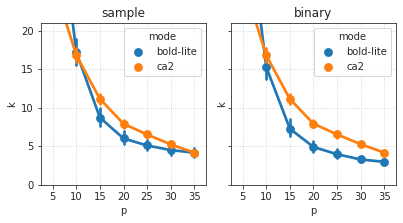

In [19]:
fig, axes = create_figure(1, 2, (5.7, 3.2), 'all', 'all')
for ax, cond in zip(axes.flat, df['cond'].unique()):
    sns.pointplot(
        data=df.loc[df['cond'] == cond],
        x='p',
        y='k',
        hue='mode',
        ax=ax,
    )
    ax.set_title(cond)
    ax.set_ylim(0, 21)
    ax.grid()
plt.show()

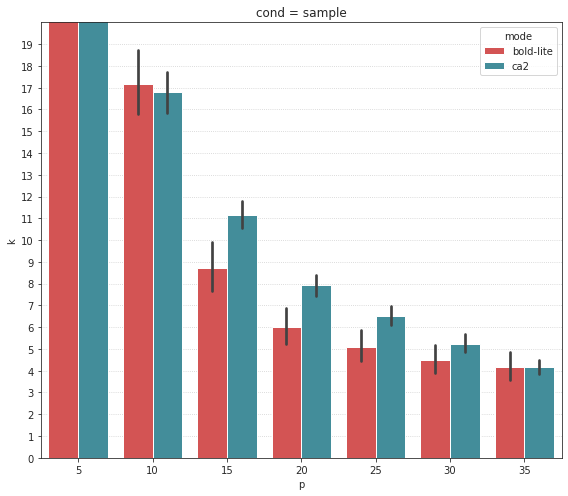

In [23]:
fig, ax = create_figure(figsize=(8, 7))

sns.barplot(
    data=df.loc[df['cond'] == 'sample'],
    x='p',
    y='k',
    hue='mode',
    palette=pal,
    ax=ax,
)
ax.set_yticks(range(20))
ax.grid(axis='y')
ax.set_ylim(0, 20)
ax.set_title('cond = sample')
plt.show()

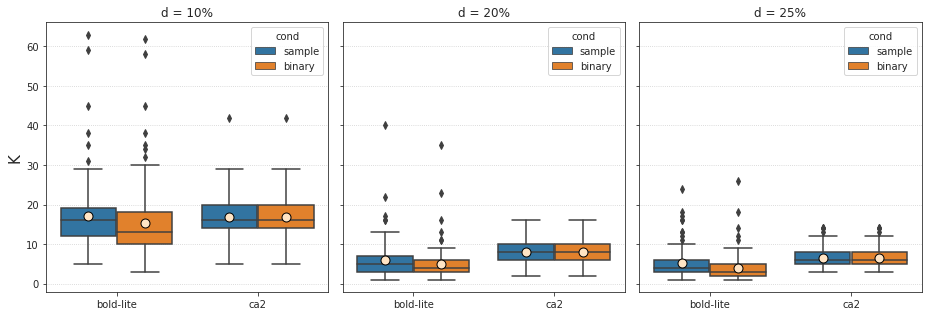

In [21]:
meanprops = {
    'markerfacecolor': 'bisque',
    'marker': 'o',
    'markersize': 9,
    "markeredgecolor":"k",
}

fig, axes = create_figure(1, 3, (13, 4.5), 'all', 'all')
for ax, p in zip(axes.flat, [10, 20, 25]):
    sns.boxplot(
        data=df.loc[df['p'] == p],
        y='k',
        hue='cond',
        x='mode',
        showmeans=True,
        meanprops=meanprops,
        ax=ax,
    )
    ax.grid(axis='y')
    ax.set_xlabel('')
    ax.set_title(f"d = {p}%")
    ax.set_ylabel('K' if p == 10 else '', fontsize=15)
plt.show()